# Variational simulation study
## Setup

In [1]:
import yaml
import json
import pickle
import newick
import pymc3 as pm
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import sys
import os
import templating
import variational_analysis
import topology_inference
import subprocess
import process_results
import util
import Bio
import Bio.Phylo

/Users/cswa648/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('config.yaml') as f:
    config = yaml.load(f)

config

{'beast_jar': 'lib/feast.jar',
 'lsd_executable': 'lsd',
 'n_taxa': 20,
 'sampling_window': 20,
 'sequence_length': 1000,
 'relaxed_clock': False,
 'mutation_rate': 0.001,
 'kappa': 2.0,
 'frequencies': [0.24, 0.26, 0.26, 0.24],
 'rate_sd': None,
 'chain_length': 100000,
 'log_every': 100,
 'estimate_clock_rate': False,
 'prior_params': {'clock_rate': {'m': 1.0, 's': 1.25},
  'pop_size': {'m': 2, 's': 0.1},
  'kappa': {'m': 1.0, 's': 1.25}},
 'init_values': {'clock_rate': 1.0, 'pop_size': 1000, 'kappa': 2.0},
 'estimate_topology': False,
 'n_iter': 20000,
 'inference': 'mean_field',
 'burn_in': 0.1,
 'n_runs': 3,
 'n_eval_samples': 200,
 'nuts_draws': 10000,
 'nuts_tune': 100,
 'n_trace_samples': 1000,
 'out_dir': 'out/0',
 'seed': 1}

In [3]:
util.do_seeding(config)
out_dir = config['out_dir']
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
build_templates = templating.TemplateBuilder(out_dir)

## Simulation

### Population size

array([6.07391639, 8.98895318])

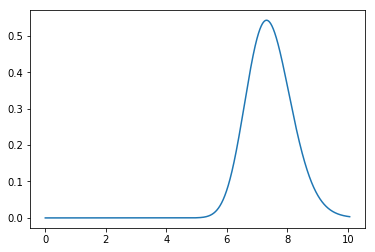

In [4]:
pop_size_prior = scipy.stats.lognorm(scale=np.exp(config['prior_params']['pop_size']['m']), s=config['prior_params']['pop_size']['s'])
xs = np.arange(0, pop_size_prior.ppf(0.999), 0.001)
plt.plot(xs, pop_size_prior.pdf(xs))
pop_size_prior.ppf([0.025, 0.975])

In [5]:
beast_args = ['java'] + util.cmd_kwargs(jar=config['beast_jar'], seed=config['seed']) + ['-overwrite']
pop_size, taxon_names, date_trait_string = build_templates.build_tree_sim(config)
pop_size

8.692273576071088

### Sampling times

18.863292844056232

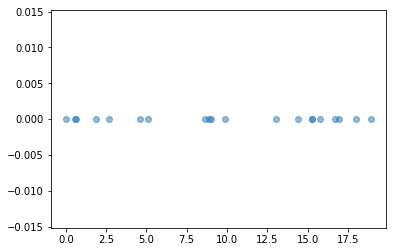

In [6]:
import statsmodels
date_trait_dict = topology_inference.parse_date_trait_string(date_trait_string)
sampling_times = list(date_trait_dict.values())
plt.scatter(sampling_times, np.zeros_like(sampling_times), alpha=0.5);
np.max(sampling_times) - np.min(sampling_times)

### Tree simulation

Ran BEAST (out/0/sim-tree.xml) successfully


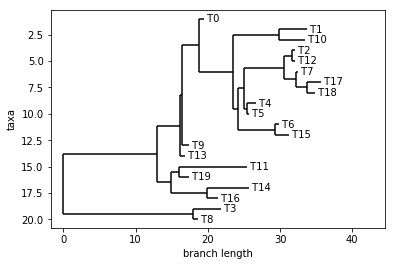

35.67151

In [7]:
from io import StringIO

def run_beast(xml_path, **kwargs):
    result = subprocess.run(beast_args + [xml_path], **kwargs)
    if result.returncode != 0:
        print(result.stderr)
        print(result.stdout)
        raise RuntimeError('BEAST run failed')
    else:
        print('Ran BEAST ({0}) successfully'.format(xml_path))
    

run_beast(build_templates.tree_sim_out_path)
newick_string = build_templates.extract_newick_string(build_templates.tree_sim_result_path)
bio_tree = next(Bio.Phylo.parse(StringIO(newick_string), 'newick'))
Bio.Phylo.draw(bio_tree)
tree_height = max(bio_tree.depths().values())
tree_height

In [8]:
newick_string

'(((((T0:0.62161,((T1:3.81443,T10:3.58106):6.36567,((((T2:0.45377,T12:0.42388):1.09929,(T7:0.28143,(T17:1.94993,T18:1.07306):1.46245):1.77061):5.43921,(T4:1.20761,T5:0.28873):0.41788):0.89199,(T6:0.54133,T15:1.94027):5.09930):0.62265):4.70290):2.37447,T9:0.87575):0.36855,T13:0.71947):3.17489,((T11:9.44718,T19:1.40364):1.13700,(T14:5.82737,T16:1.49488):5.00920):1.92340):12.91386,(T3:3.94968,T8:0.72549):17.91779):0.00000;'

In [9]:
run_summary = {
    'config': config,
    'pop_size': pop_size,
    'date_trait_string': date_trait_string,
    'newick_string': newick_string
}

with(open(build_templates.run_summary_path, 'w')) as f:
    yaml.dump(run_summary, f)

### Sequence simulation

In [10]:
build_templates.build_seq_sim(config, taxon_names, newick_string)
run_beast(build_templates.seq_sim_out_path)
sequence_dict = build_templates.extract_sequence_dict()
sequence_values = [pd.Series(list(x)) for x in sequence_dict.values()]
char_counts = pd.concat(sequence_values).value_counts()
char_counts / sum(char_counts)

Ran BEAST (out/0/sim-seq.xml) successfully


A    0.25200
C    0.25085
T    0.24900
G    0.24815
dtype: float64

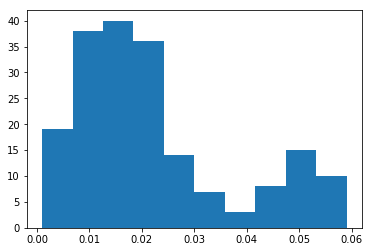

In [11]:
from itertools import combinations

prop_differences = [np.mean(x != y) for x, y in combinations(sequence_values, 2)]
plt.hist(prop_differences);

## Inference

### Neighbour joining

In [12]:
from importlib import reload
reload(topology_inference)

<module 'topology_inference' from '/Users/cswa648/git/pylo/eval/topology_inference.py'>

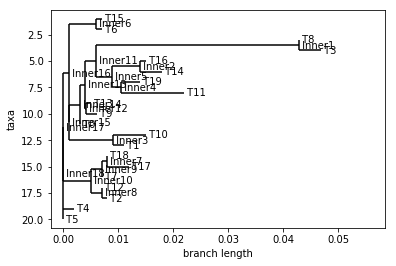

In [13]:
nj_tree = topology_inference.get_neighbor_joining_tree(sequence_dict)
Bio.Phylo.draw(nj_tree)

### Rooting & dating

In [14]:
topology_inference.build_lsd_inputs(config, build_templates, nj_tree, date_trait_string)
subprocess.run([config['lsd_executable']] + topology_inference.get_lsd_args(build_templates))

CompletedProcess(args=['lsd', '-c', '-r', 'a', '-i', 'out/0/lsd-input.trees', '-d', 'out/0/lsd-input.dates', '-w', 'out/0/lsd-input.rates', '-o', 'out/0/analysis-tree'], returncode=0)

'((T3:3.61209,T8:0.38791):21.11580,(((((((T5:0.70765,T4:1.62653):0.33419,((T2:0.40669,T12:0.37680):1.78349,((T17:2.44770,T18:1.57084):1.01855,T7:0.33530):2.35385):5.13734):1.47152,(T6:0.71882,T15:2.11776):5.83658):1.36811,(T1:4.04457,T10:3.81119):7.79576):3.10387,T0:0.68280):2.80767,(T9:1.36913,T13:0.84430):0.00100):2.99910,((T11:10.66040,T19:2.61688):0.02731,(T14:5.00754,T16:0.67505):5.93259):1.76990):15.82420):0.00000;\n'

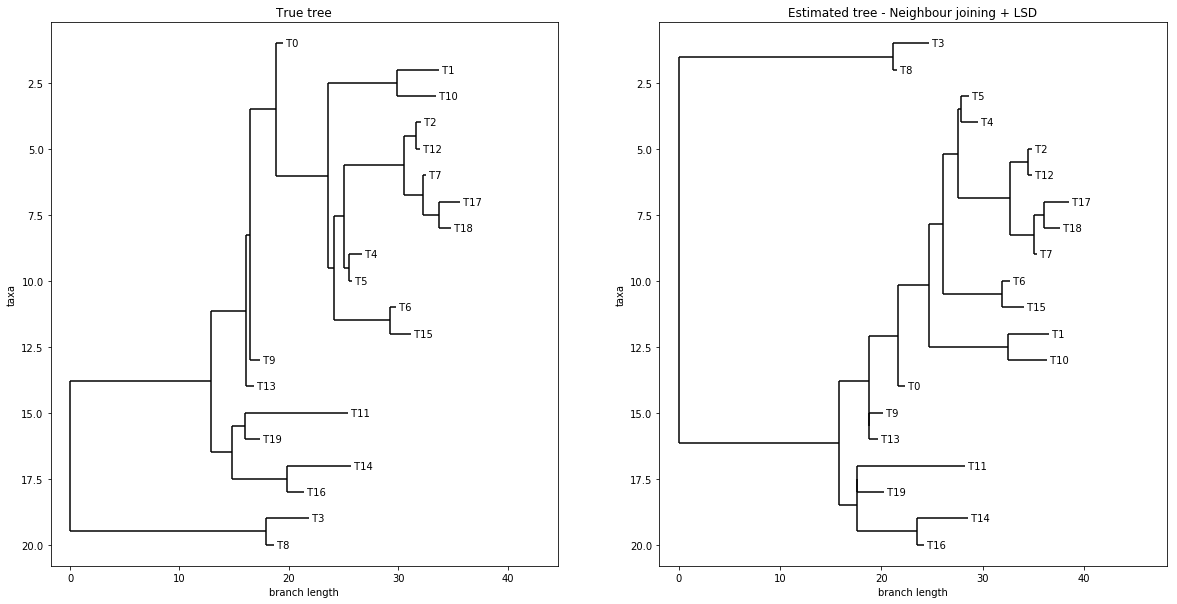

In [15]:
lsd_tree = topology_inference.extract_lsd_tree(build_templates)    
analysis_newick_io = StringIO()
Bio.Phylo.write([lsd_tree], analysis_newick_io, format='newick')
analysis_newick = analysis_newick_io.getvalue()
    
fig, axs = plt.subplots(ncols=2, figsize=(20,10))
Bio.Phylo.draw(bio_tree, axes=axs[0], do_show=False)
axs[0].set_title('True tree')
Bio.Phylo.draw(lsd_tree, show_confidence=False, axes=axs[1], do_show=False)
axs[1].set_title('Estimated tree - Neighbour joining + LSD');
analysis_newick

### BEAST analysis (estimating tree)

In [16]:
def update_dict(dict, **kwargs):
    res = dict.copy()
    res.update(**kwargs)
    return res

build_templates.build_beast_analysis(update_dict(config, estimate_topology=True), analysis_newick, date_trait_string, sequence_dict)
run_beast(build_templates.beast_analysis_out_path)

Ran BEAST (out/0/beast-analysis.xml) successfully


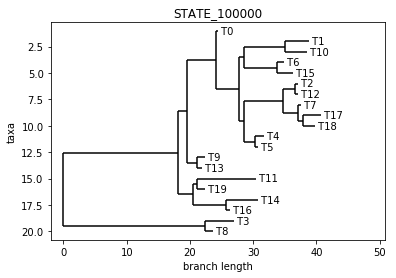

In [17]:
with open(build_templates.beast_analysis_tree_path) as f:
    beast_trees = list(Bio.Phylo.parse(f, 'nexus'))
    
Bio.Phylo.draw(beast_trees[-1])

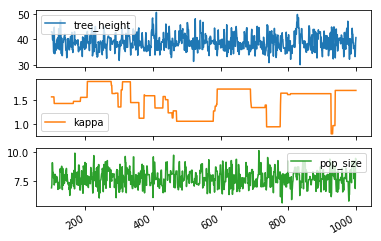

In [18]:
beast_trace_df = process_results.process_beast_trace(build_templates.beast_analysis_trace_path, config)
beast_trace_df.plot(subplots=True);

In [19]:
# TODO: Effective sample size

In [20]:
true_values = {
    'tree_height': tree_height,
    'pop_size': pop_size,
    'kappa': config['kappa']
}

p_limits = np.array([0.025, 0.975])

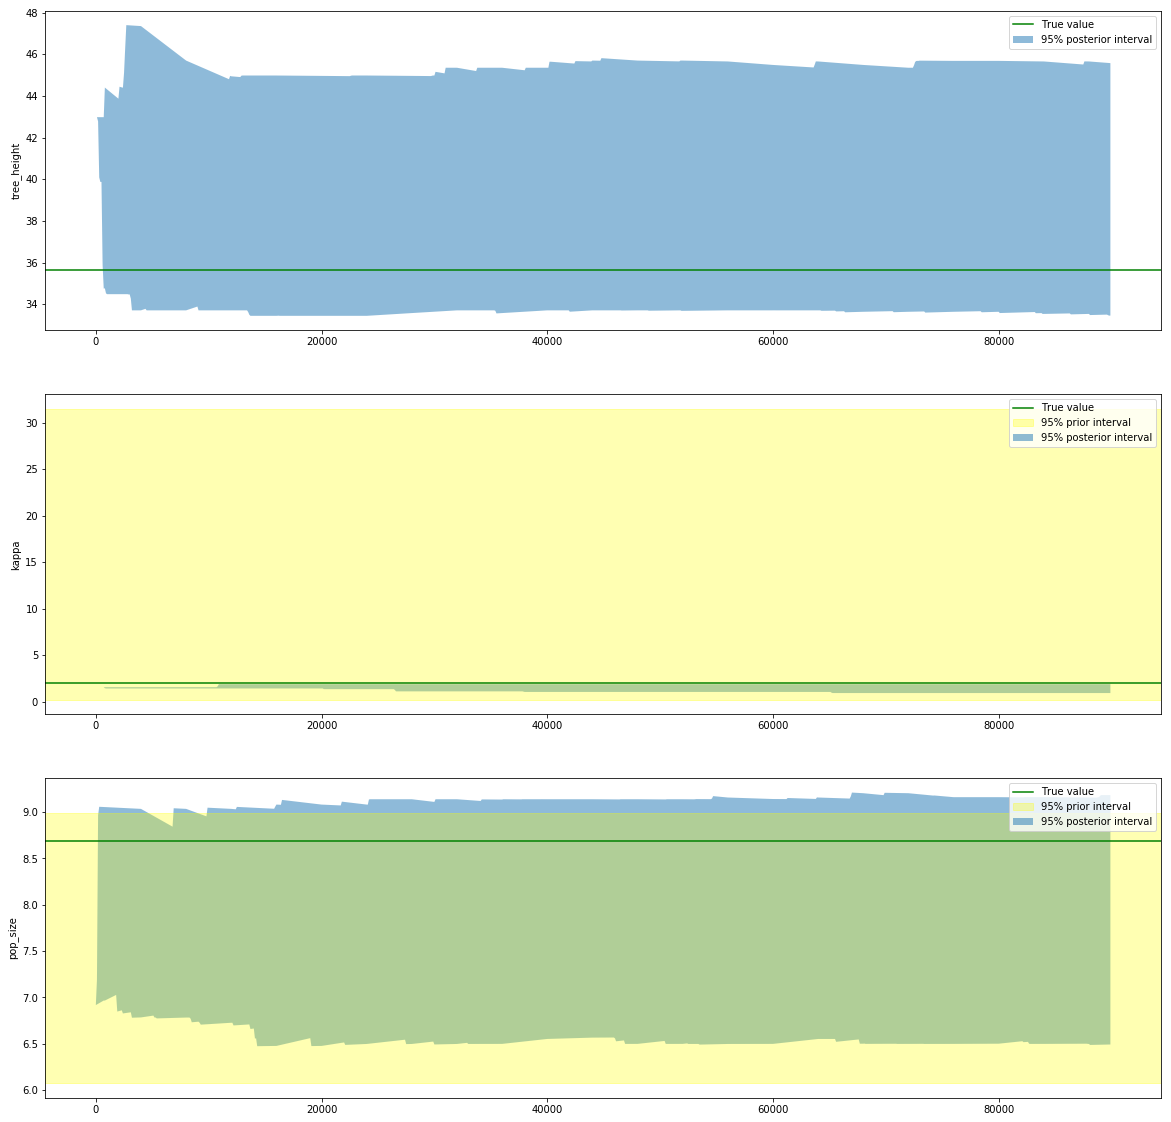

In [21]:
def get_beast_quantiles(trace, ps):
    return np.stack([np.quantile(trace.values[:i], ps, axis=0) for i in range(1, trace.shape[0])])

def plot_trace_hpd(quantiles, varnames, xs=None): # quantiles: iteration, p, var
    n_vars = quantiles.shape[2]
    if xs is None:
        xs = np.arange(quantiles.shape[0])
    fig, axs = plt.subplots(nrows=n_vars, figsize=(20, 20))
    for j in range(n_vars):
        ax = axs[j]
        varname = varnames[j]
        ax.set_ylabel(varname)
        
        ax.fill_between(xs, quantiles[:, 0, j], quantiles[:, 1, j], alpha=0.5, label='95% posterior interval')
        
        if varname in config['prior_params']:
            prior = scipy.stats.lognorm(scale=np.exp(config['prior_params'][varname]['m']), s=config['prior_params'][varname]['s'])
            ax.axhspan(*prior.ppf(p_limits), color='yellow', alpha=0.3, label='95% prior interval')
        
        ax.axhline(true_values[varname], color='green', label='True value')
        
        ax.legend()
plot_trace_hpd(get_beast_quantiles(beast_trace_df, p_limits), beast_trace_df.columns, xs=np.arange(beast_trace_df.shape[0] - 1)*config['log_every'])

### BEAST analysis (fixed tree)


In [22]:
beast_fixed_out_file = 'beast-analysis-fixed.xml'
beast_fixed_trace_file = 'beast-log-fixed.log'
beast_fixed_tree_file = 'beast-log-fixed.trees'

build_templates.build_beast_analysis(update_dict(config, estimate_topology=False),
                                     analysis_newick,
                                     date_trait_string,
                                     sequence_dict,
                                     out_file=beast_fixed_out_file,
                                     trace_file=beast_fixed_trace_file,
                                     tree_file=beast_fixed_tree_file
                                    )
run_beast(build_templates.out_path / beast_fixed_out_file)

Ran BEAST (out/0/beast-analysis-fixed.xml) successfully


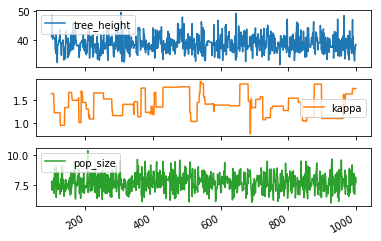

In [23]:
beast_fixed_trace_df = process_results.process_beast_trace(build_templates.out_path / beast_fixed_trace_file, config)
beast_fixed_trace_df.plot(subplots=True);

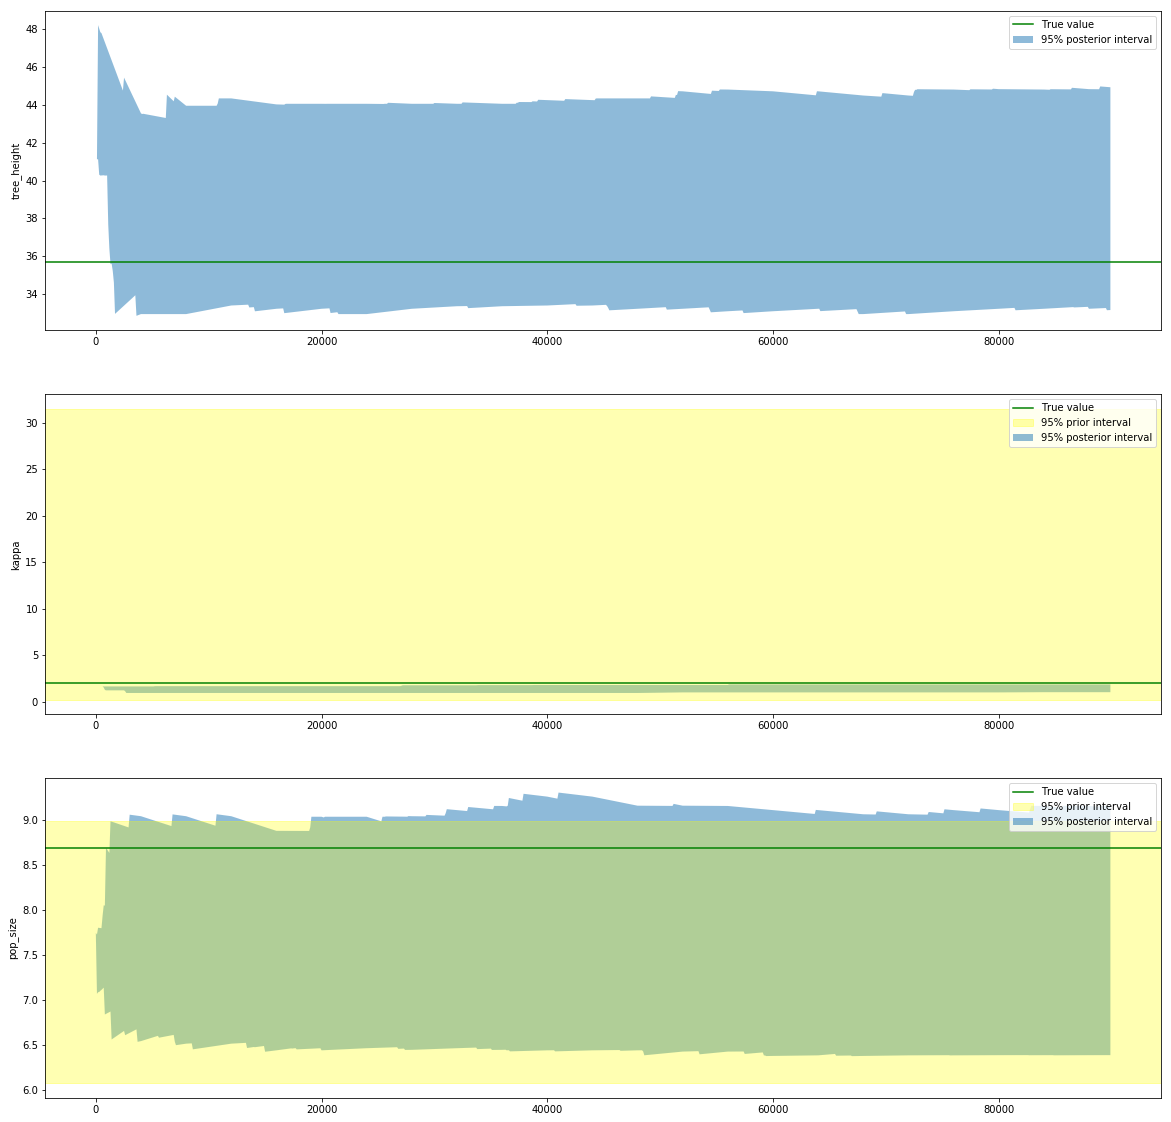

In [24]:
plot_trace_hpd(get_beast_quantiles(beast_fixed_trace_df, p_limits), beast_fixed_trace_df.columns, xs=np.arange(beast_fixed_trace_df.shape[0] - 1)*config['log_every'])

### Variational analysis (true tree)

In [25]:
tree = newick.loads(analysis_newick)[0]
model = variational_analysis.construct_model(config, tree, sequence_dict)
inference = variational_analysis.construct_inference(config, model)
print(model.logp(model.test_point))
model

/Users/cswa648/envs/python36/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/cswa648/envs/python36/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/cswa648/envs/python36/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

-2315.6224397196033


  0%|          | 0/20000 [00:00<?, ?it/s]/Users/cswa648/envs/python36/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/cswa648/envs/python36/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 2,289.5: 100%|██████████| 20000/20000 [02:39<00:00, 125.63it/s]
Finished [100%]: Average Loss = 2,289.5


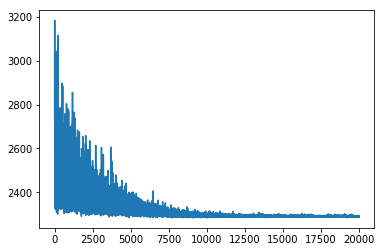

In [26]:
tracker = pm.callbacks.Tracker(
   mean=inference.approx.mean.eval,
   std=inference.approx.std.eval
)

approx = inference.fit(config['n_iter'], callbacks=[tracker])

with open(build_templates.pymc_analysis_result_path, 'wb') as f:
    pickle.dump(tracker, f)

plt.plot(approx.hist)

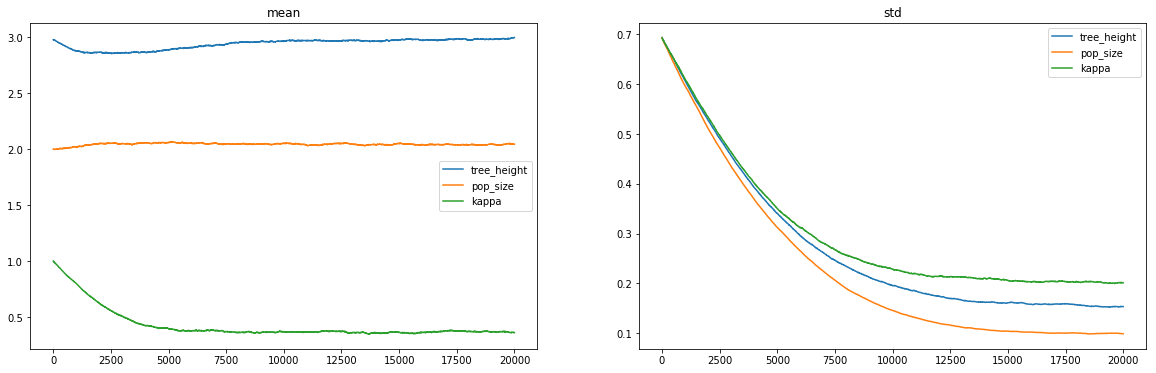

In [27]:
rvs_dict = { rv.name: rv for rv in model.deterministics }
slices = { name: inference.approx.ordering.by_name[rv.transformed.name].slc for name, rv in rvs_dict.items() }
indices_dict = { 'tree_height': slices['tree'].stop - 1, 'pop_size': slices['pop_size'].start, 'kappa': slices['kappa'].start  }

means = np.stack(tracker.hist['mean'])
stds = np.stack(tracker.hist['std'])

varnames = list(indices_dict.keys())
indices = np.array(list(indices_dict.values()))

fig, axs = plt.subplots(ncols=len(tracker.hist), figsize=(20, 6))

for ax, (name, param) in zip(axs, tracker.hist.items()):
    ax.set_title(name)
    vals = np.stack(param)
    for varname, index in zip(varnames, indices):
        ax.plot(vals[:, index], label=varname)
    ax.legend()

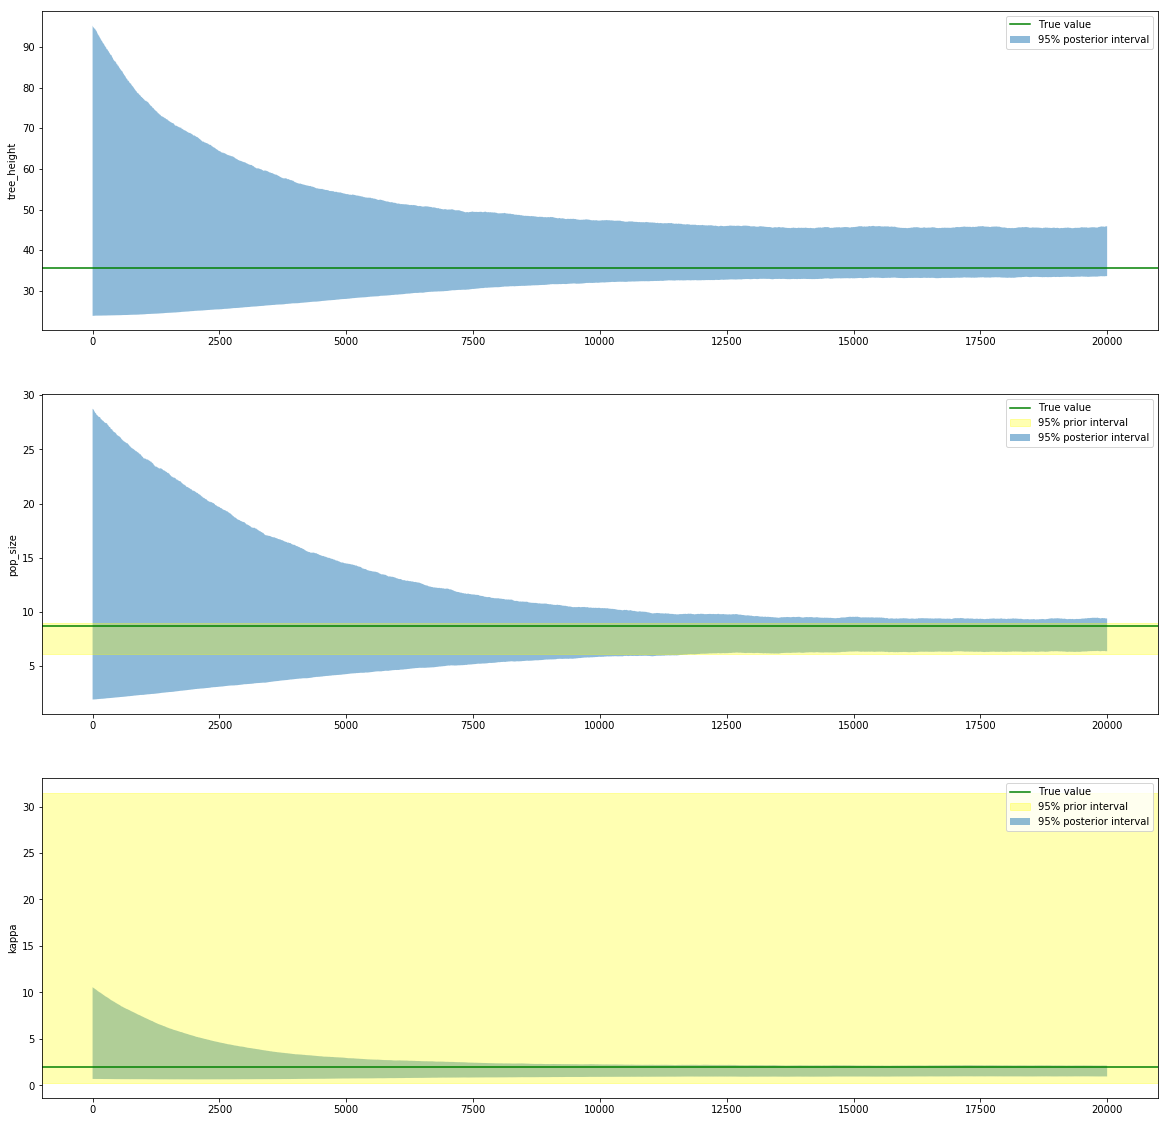

In [28]:
from pylo.topology import TreeTopology
topology = TreeTopology(tree)

transformed_quantiles = scipy.stats.norm.ppf(p_limits[np.newaxis, :, np.newaxis],
                                             loc=means[:, np.newaxis, indices],
                                             scale=stds[:, np.newaxis, indices])

transforms = {
    'tree_height': lambda x: np.exp(x) + topology.get_max_leaf_height(),
    'kappa': np.exp,
    'pop_size': np.exp
}

quantiles = np.stack([transforms[varname](transformed_quantiles[:, :, i]) for i, varname in enumerate(varnames)], axis=-1)
plot_trace_hpd(quantiles, varnames)